In [10]:
#| default_exp use

In [1]:
import pandas as pd
from cylinder.hwc import HWC
from cylinder.demand import *
from cylinder.power import *
import pandas as pd	
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import defaultdict


Use the model in repeatable conditions to estabish different patterns from operation

Load some representative wholesale power price data 

In [4]:
load_power(path = Path('../data/'))

,price,ripple_control,price_kw,date,week,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,7.920,False,0.007920,2020-01-01,1,0,2,0,0.02,0.027920,-0.22080,0.162438,0.149272
2020-01-01 00:01:00,8.526,False,0.008526,2020-01-01,1,0,2,0,0.02,0.028526,-0.21474,0.158675,0.145694
2020-01-01 00:02:00,9.132,False,0.009132,2020-01-01,1,0,2,0,0.02,0.029132,-0.20868,0.155010,0.142235
2020-01-01 00:03:00,9.738,False,0.009738,2020-01-01,1,0,2,0,0.02,0.029738,-0.20262,0.151437,0.138888
2020-01-01 00:04:00,10.344,False,0.010344,2020-01-01,1,0,2,0,0.02,0.030344,-0.19656,0.147952,0.135645
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:51:00,77.170,False,0.077170,2020-12-31,53,21,3,0,0.02,0.097170,0.47170,0.181917,0.194701
2020-12-31 21:52:00,77.170,False,0.077170,2020-12-31,53,21,3,0,0.02,0.097170,0.47170,0.182253,0.194996
2020-12-31 21:53:00,77.170,False,0.077170,2020-12-31,53,21,3,0,0.02,0.097170,0.47170,0.182548,0.195280


Load some flow data 

In [3]:
load_demand(path = Path('../data/drawprofiles'),bed=3,unit=3).loc[:,'flow']

timestamp
2020-01-01 00:00:00    0.0
2020-01-01 00:01:00    0.0
2020-01-01 00:02:00    0.0
2020-01-01 00:03:00    0.0
2020-01-01 00:04:00    0.0
                      ... 
2020-12-30 23:55:00    0.0
2020-12-30 23:56:00    0.0
2020-12-30 23:57:00    0.0
2020-12-30 23:58:00    0.0
2020-12-30 23:59:00    0.0
Name: flow, Length: 525600, dtype: float64

Establish some operational parameters and control strategies

Set a function to run the different strategies operating on the thermostat as this is all that the strategy can effectively control

[1 1]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [56.07753063 55.78862004 55.49970944 55.21079884 54.92188824 54.63297764
 54.34406705 54.05515645 53.76624585 53.47733525]
[ 20.77708898 322.75269418 159.9266282   52.14932951   5.06539275
   1.           1.           1.           1.           1.        ] [50.47987912 50.5214333  50.55250143 50.57309187 50.58322266 50.58291915
 50.57221123 50.55113037 50.51970681 50.47796718]
[0.1 0.1 0.1 0.1 1.  1.  1.  1.  1.  1. ] [47.28888786 47.28902894 47.28903587 47.28904382 47.28893494 47.28143464
 47.24161999 47.19998315 47.15652491 47.11124656]
[1.54861599e+02 1.62826003e+04 6.42989785e+03 1.50353145e+02
 2.45860334e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00] [43.28029158 43.59001478 43.80030062 43.92260839 43.92752559 43.92085501
 43.90703695 43.88608573 43.85801486 43.82283691]
[0.1 0.1 0.1 0.1 1.  1.  1.  1.  1.  1. ] [41.11820117 41.11820351 41.11820353 41.11820353 41.11810602 41.10318527
 41.06623822 41.02901998 4

Text(0.5, 0.98, 'Passive Losses - No Heating + No Flow over 6 minutes')

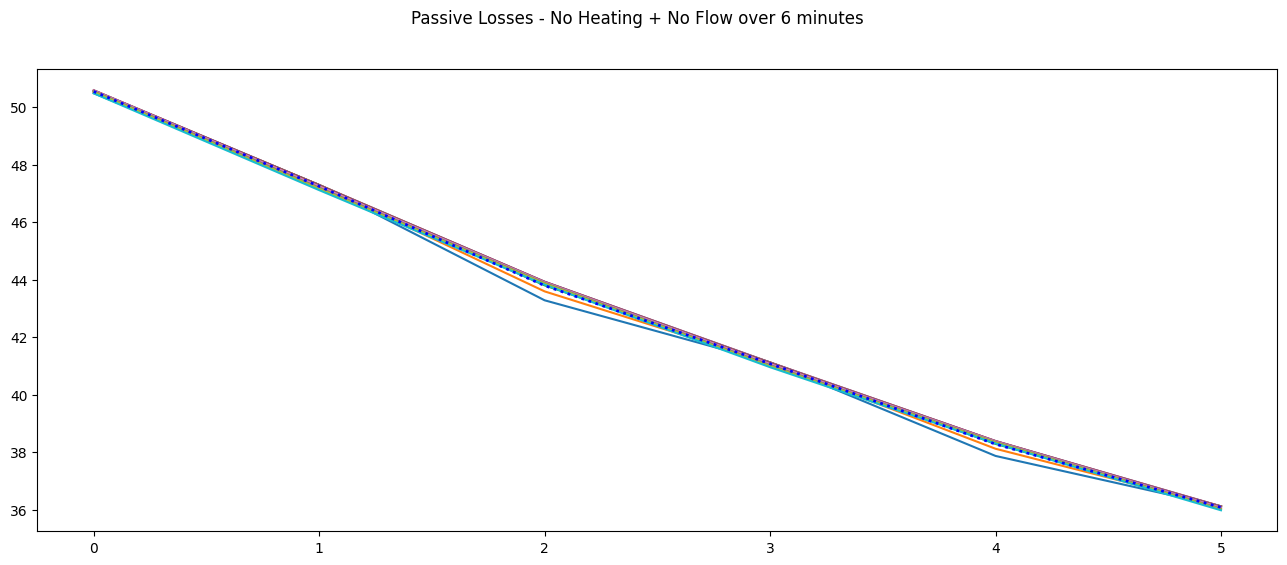

In [28]:
def simulation(strategy=None,bedrooms=4,element=3,tset_h=60,tset_l=60,ripple=False,steps=6):
    env = HWC(T_set=tset_h, element=element, delta=500, nodes=10, U=.8)
    temp = []
    flow = load_demand(path = Path('../data/drawprofiles'),bed=bedrooms,unit=3).loc[:,'flow']
    # if ripple:
    #     flow = flow.rolling(window=10).mean()
    print(env.thermostat)
    for i in range(steps):
        env._thermostat()
        # import pdb; pdb.set_trace()
        if env.thermostat[1] == 1:
            action = 1
        action = 0
        env._update_model(action = action , flow = 0, timestep_sec=60)
        temp.append(env.temperatures)
    return steps, np.vstack(temp)


In [16]:
power = load_power(path = Path('../data/'))
# power = power.loc[:,'power']
power

,price,ripple_control,price_kw,date,week,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,7.920,False,0.007920,2020-01-01,1,0,2,0,0.02,0.027920,-0.22080,0.162438,0.149272
2020-01-01 00:01:00,8.526,False,0.008526,2020-01-01,1,0,2,0,0.02,0.028526,-0.21474,0.158675,0.145694
2020-01-01 00:02:00,9.132,False,0.009132,2020-01-01,1,0,2,0,0.02,0.029132,-0.20868,0.155010,0.142235
2020-01-01 00:03:00,9.738,False,0.009738,2020-01-01,1,0,2,0,0.02,0.029738,-0.20262,0.151437,0.138888
2020-01-01 00:04:00,10.344,False,0.010344,2020-01-01,1,0,2,0,0.02,0.030344,-0.19656,0.147952,0.135645
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:51:00,77.170,False,0.077170,2020-12-31,53,21,3,0,0.02,0.097170,0.47170,0.181917,0.194701
2020-12-31 21:52:00,77.170,False,0.077170,2020-12-31,53,21,3,0,0.02,0.097170,0.47170,0.182253,0.194996
2020-12-31 21:53:00,77.170,False,0.077170,2020-12-31,53,21,3,0,0.02,0.097170,0.47170,0.182548,0.195280


In [14]:
flow = load_demand(path = Path('../data/drawprofiles'),
                      bed=3,
                      unit=3).loc[:,'flow']
for row in power.loc['2020-02'].itertuples():
    print(flow.loc[row.Index])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [36]:
# Initialize an empty dictionary
strategies = {}

# Add some keys and values to the dictionary
# stategies[0] = 'description1'    
strategies[0] = {'name': 'Stategy 1',
            'operation': 'continuous',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 60,
            'Tset_L' : 60,
            'radius' : 0.5,
            'height' : 1.5,
            'ripple' : False}
strategies[1] = {'name': 'Stategy 2',
            'operation': 'off_peak',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 75,
            'Tset_L' : 60,
            'radius' : 0.5,
            'height' : 1.5,
            'ripple' : True}

Add functionality for a thermostat

In [ ]:
#| export
@patch
def _thermostat(self:HWC):
    "Thermostat state change"
    # Nodal cylinder thermostat
    self.thermostat[0] = 0 if self.temperatures[self.nodes-2] > self.T_set else self.thermostat[0] # Turn off if T > T_set
    self.thermostat[0] = 1 if self.temperatures[self.nodes-2] < self.T_set- self.T_deadband else self.thermostat[0] # Turn on the element
    # Nodal cylinder thermostat
    self.thermostat[1] = 0 if self.temperatures[self.nodes-2] > self.T_set_bu else self.thermostat[1] # Turn off if T > T_set
    self.thermostat[1] = 1 if self.temperatures[self.nodes-2] < self.T_set_bu- self.T_deadband else self.thermostat[1] # Turn on the element
    return self.thermostat

In [76]:
res = [] 
time_period = '2020-02-01'
power = load_power(path = Path('../data/'))
power.loc['2020-02-01 12','ripple_control'] = True
nodes = 10
for strategy in strategies:
    # print(strategies[strategy])

    env = HWC(T_set=strategies[strategy]['Tset_H'], 
              element=strategies[strategy]['bedrooms'],
              delta=500, 
              nodes=nodes)
    temp = []
    flow = load_demand(path = Path('../data/drawprofiles'),
                      bed=strategies[strategy]['bedrooms'],
                      unit=3).loc[:,'flow']
    for row in power.loc[time_period].itertuples(): # go through a set time period
        action = 0
        raw_flow = flow.loc[row.Index]
        # adjust for temperature
        env._thermostat()
        # import pdb; pdb.set_trace()
        # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
        if env.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
            if strategies[strategy]['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = ~row.peak
            elif strategies[strategy]['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = 1
            elif strategies[strategy]['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = 1 if row.cost < 0.1 else 0

        if env.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
            action = 1

        if strategies[strategy]['ripple']: # if ripple control is on then override the thermostat state
            action *= row.ripple_control 

        env._update_model(action = action , flow = raw_flow, timestep_sec=60)
        temp.append([strategy,
                    action,
                    row.ripple_control,
                    *env.thermostat,
                    *env.temperatures])
    res.append(pd.DataFrame(temp, 
                            columns=['strategy',
                                     'action',
                                     'ripple_control',
                                     'thermostat_high',
                                     'thermostat_base']+[f'T{i}' for i in range(nodes)]))
# fig, ax = plt.subplots(figsize=(16,6))
# ax.plot(res)
# ax.plot(res.mean(axis=1), lw=2, ls=':', c='blue')
# fig.suptitle(f'Passive Losses - No Heating + No Flow over {steps} minutes') 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [55.65266305 55.27274822 54.89283338 54.51291855 54.13300371 53.75308888
 53.37317404 52.99325921 52.61334437 52.23342954]
[1.36677643e+02 3.27158683e+04 8.19736053e+04 1.52771033e+05
 2.45524745e+05 3.60750423e+05 4.99058829e+05 7.61398850e+02
 1.00000000e+00 1.00000000e+00] [61.73305106 62.00640635 62.4851367  63.17006177 64.06225299 65.16302485
 66.47392472 67.99672242 67.94067932 67.65021061]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.  1.  1. ] [60.60316353 60.60316557 60.60316558 60.60316558 60.60316558 60.60316558
 60.60316558 60.60316558 60.60307788 60.536298  ]
[2.18039617e+02 3.10486795e+04 9.51692592e+03 6.68326934e+01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00] [55.02939179 55.46547102 55.75026954 55.88393493 55.86475448 55.68742609
 55.34290546 55.29062577 55.26746836 55.22638331]
[1.00000000e-01 1.00000000e-01 1.00000000e-01 1.59844832e+00
 1.70745058e+04 1.14271968e+06 1.14785991e+06 1.94728014e+05
 1.8

In [89]:
df = pd.concat([power.loc[time_period].reset_index(),
                flow.loc[time_period].reset_index(drop=True),
                res[0]],axis=1).set_index('timestamp')

In [90]:
df

,price,ripple_control,price_kw,date,week,hour,day,peak,tou,cost,...,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0.130,False,0.000130,2020-02-01,5,0,5,0,0.02,0.020130,...,61.733051,62.006406,62.485137,63.170062,64.062253,65.163025,66.473925,67.996722,67.940679,67.650211
2020-02-01 00:01:00,0.126,False,0.000126,2020-02-01,5,0,5,0,0.02,0.020126,...,60.603164,60.603166,60.603166,60.603166,60.603166,60.603166,60.603166,60.603166,60.603078,60.536298
2020-02-01 00:02:00,0.122,False,0.000122,2020-02-01,5,0,5,0,0.02,0.020122,...,55.029392,55.465471,55.750270,55.883935,55.864754,55.687426,55.342905,55.290626,55.267468,55.226383
2020-02-01 00:03:00,0.118,False,0.000118,2020-02-01,5,0,5,0,0.02,0.020118,...,51.958365,51.958367,51.958367,51.958371,51.990339,54.126725,56.266263,58.412258,58.775219,58.700504
2020-02-01 00:04:00,0.114,False,0.000114,2020-02-01,5,0,5,0,0.02,0.020114,...,56.004364,57.879810,61.075197,61.362047,61.362057,61.362057,61.362057,61.362058,61.362060,61.360916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01 23:55:00,0.030,False,0.000030,2020-02-01,5,23,5,0,0.02,0.020030,...,57.025947,57.026111,57.050109,60.634336,60.971626,60.987922,60.987102,60.969421,60.935079,60.884218
2020-02-01 23:56:00,0.132,False,0.000132,2020-02-01,5,23,5,0,0.02,0.020132,...,56.366998,56.417563,56.417563,56.417563,56.417563,56.417558,56.410137,56.349669,56.289201,56.228733
2020-02-01 23:57:00,0.234,False,0.000234,2020-02-01,5,23,5,0,0.02,0.020234,...,49.156073,49.202739,60.553825,73.227422,74.805197,75.291308,76.107644,77.256198,76.946344,76.522505


/tmp/ipykernel_25410/3119032717.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row in ser.iteritems():


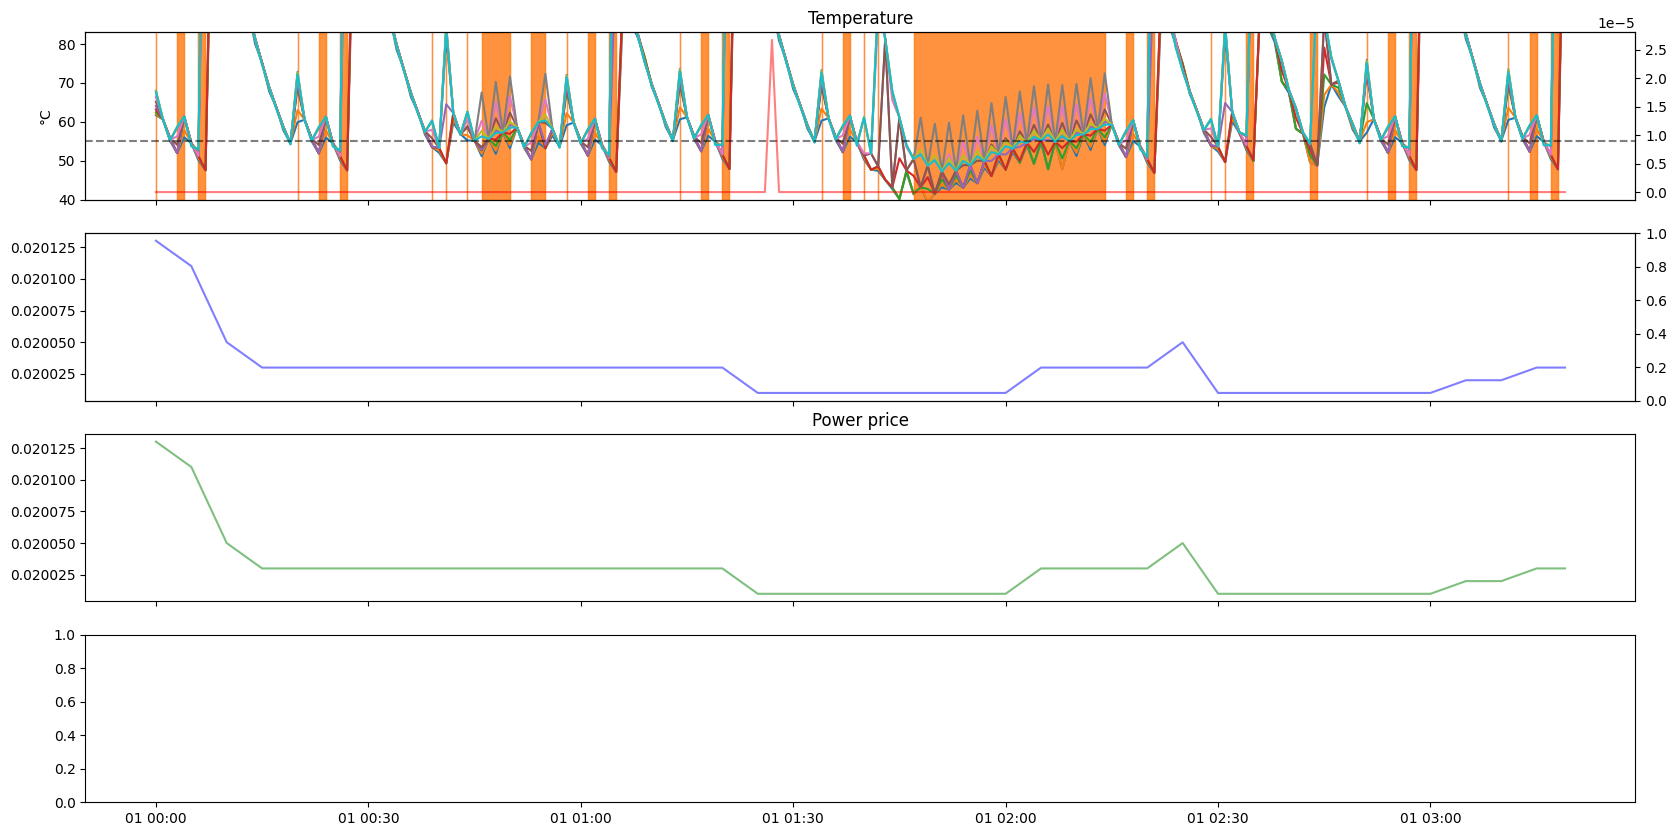

In [99]:
tmp = df[:200]

fig, ax = plt.subplots(nrows=4,figsize=(20,10), sharex=True)
# ax.plot(df.action*1)
for i in range(10):
    ax[0].plot(tmp[f'T{i}'])
ax[0].set_ylim(40,83)
ax[0].set_title('Temperature')
ax[0].set_ylabel('°C')

for i in series_timestamps((tmp.thermostat_base == 1)): ax[0].axvspan(i[0], i[1], color='red', alpha=0.5)
for i in series_timestamps((tmp.action == 1)&(tmp.thermostat_high == 1)): ax[0].axvspan(i[0], i[1], color='orange', alpha=0.5)
for i in series_timestamps((tmp.action == 1)&(tmp.thermostat_high == 0)): ax[0].axvspan(i[0], i[1], 1,1,lw=5, color='green', alpha=0.5)
for i in series_timestamps((tmp.hour.isin([7,8,9,10,17,18,19,20])) & (tmp.day<5)): ax[0].axvspan(i[0], i[1], 0,0,lw=5,color='red', alpha=1)
# ax.plot(tmp.action)
# add horizontal line
ax[0].axhline(y=55, color='k', linestyle='--', alpha = .5)
ax2 = ax[0].twinx()
ax2.plot(tmp.flow, color='red', alpha=.5)

ax[1].plot(tmp.cost, color='blue', alpha=.5)
# ax[1].plot(tmp.ncost, color='red', ls = '--', alpha=.5)
# ax[1].plot(tmp.price_indicator, color='green', ls = '--', alpha=.5)
# ax2.plot(tmp.cost, color='blue', alpha=.5)
ax3 = ax[1].twinx()
# ax[1].plot(tmp['mixed'])
# for i in series_indices((df.T_bu == 1)): ax[0].axvspan(i[0], i[1], color='red', alpha=0.5)
# for i in series_timestamps((df.action == 1)&(df.T_mixed == 1)): ax[1].axvspan(i[0], i[1], color='orange', alpha=0.5)
# for i in series_timestamps((df.action == 1)&(df.T_mixed == 0)): ax[1].axvspan(i[0], i[1], color='green', alpha=0.5)

ax[2].set_title('Power price')
ax[2].plot(tmp.cost, color='green', alpha=.5)


In [92]:
def series_timestamps(ser):
    result = []
    start, end = None , None
    # Loop through the input list
    for row in ser.iteritems():
        # If we encounter a 1, update the start and end index if needed
        if row[1] == 1:
            if start is None:
                start = row[0]
            end = row[0]
        # If we encounter a 0, append the start and end index to the result
        # and reset the start and end index
        elif row[1] == 0 and start is not None:
            result.append((start, end))
            start = None
            end = None

    # If the last element of the input list is a 1, we need to append
    # the start and end index to the result one more time
    if start is not None:
        result.append((start, end))
    return result